Max grad: (2.8620795147276424e-07-1.2133659269270942e-07j)
MAX FINAL: (0.00028234803161558187+4.4471085647103696e-05j)
MIN FINAL: (-0.16091514135164622-0.0101305591751297j)
(251, 251)
(-0.47712318844801876-0.007621639638189674j)


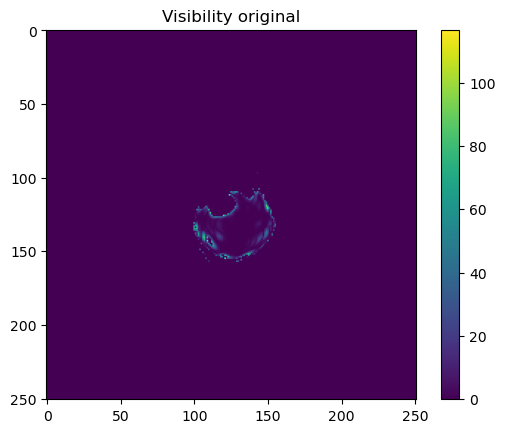

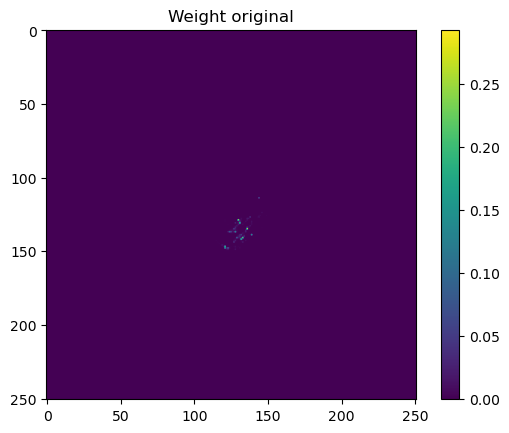

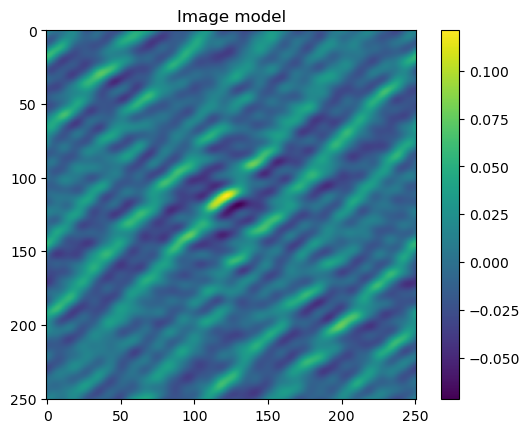

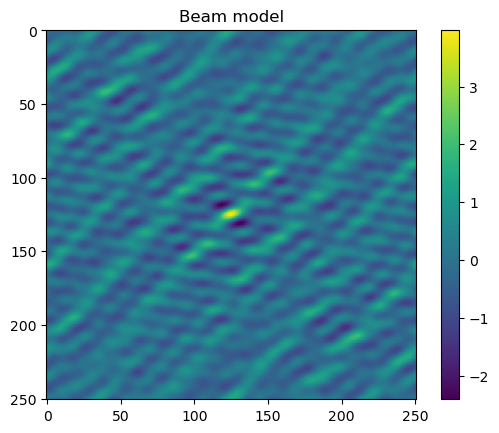

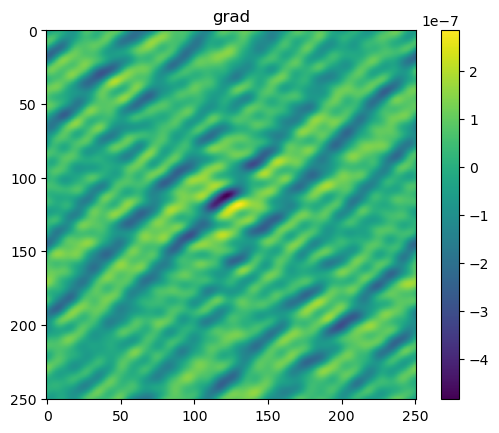

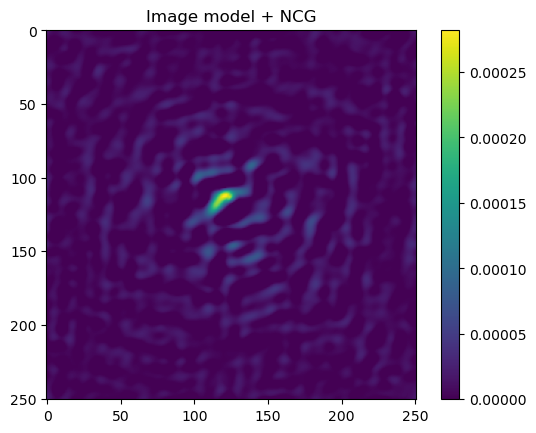

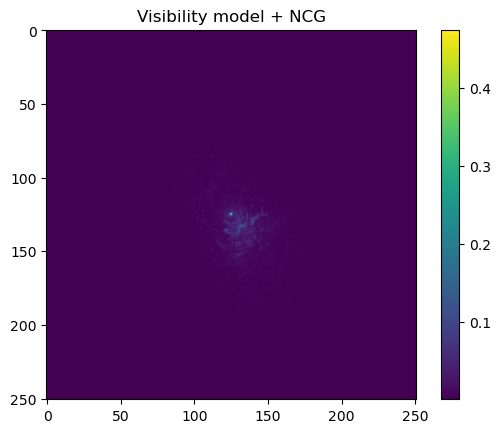

In [ ]:
from astropy.io import fits
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import animation
from math import e, pi
import math
from array import *
import time
from scipy import optimize
from scipy.signal import convolve2d as conv


def gauss(ini,dim):
    array_x = np.linspace(-ini,ini,dim)
    array_x = np.reshape(array_x,(dim,1))
    array_y = np.reshape(array_x,(1,dim))
    img = np.exp(-pi*(array_x**2 + array_y**2))**2
    return(img)

def f_alpha(x:float,Vo,Im,Wo,s):
    
    Vm2 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Im + np.real(x)*s)))

    
    return np.sum(Wo*np.absolute(Vo - Vm2)**2)

                   
def CG(Vo, Wo, n):
    
    
    Im = np.zeros_like(Vo, dtype = float)
    
    Vm = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Im)))
    
    grad = -1*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Wo*(Vo - Vm))))

    
    #print("Max grad:",np.max(grad))
    #title="grad"; fig=plt.figure(title); plt.title(title); im=plt.imshow(np.real(grad))
    #plt.colorbar(im)
    s = -grad
    
    grad_old = np.array(grad)
    
    for ite in range(0,n):
        diff = -grad
        diff_old = -grad_old

        beta = -np.conjugate(diff)*(diff-diff_old)/np.sum((diff_old*diff_old))

        beta[np.isinf(beta) == True] = 0
        beta[np.isnan(beta) == True] = 0      
 
        if ite == 0:
            s = diff
        else:
            s = diff + beta*s


        a = optimize.brent(f_alpha,args=(Vo,Im,Wo,s))

        Im = Im + a*s
        
        Im.imag[Im.real < 0] = np.trunc(Im.imag)[Im.real < 0]
        
        Im.real[Im.real < 0] = np.trunc(Im.real)[Im.real < 0]

        grad_old = np.array(grad)
        
        Vm = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Im)))
        
        grad = -1*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Wo*(Vo - Vm))))
        
        
        grad[np.isinf(grad) == True] = 0
        grad[np.isnan(grad) == True] = 0

    return Im

def norm(weights,x):
    return(np.absolute(np.sqrt(np.sum(weights*np.absolute(x)**2))))
    
N = 251

#Nombre de archivos de entradas (visibilidad y peso)
#namefile_visibilities = "gridded_visibilities_natural_501_hd100546.npz"
#namefile_weights = "gridded_weights_natural_501_hd100546.npz"


gridded_visibilities = np.load(namefile_visibilities)
gridded_visibilities = gridded_visibilities["arr_0"][:,:]


gridded_weights = np.load(namefile_weights)
gridded_weights = gridded_weights["arr_0"][:,:]

image_original = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gridded_visibilities*gridded_weights/np.sum(gridded_weights.flatten()))))*N**2
image_original = np.array(image_original.real)

beam_original = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gridded_weights/np.sum(gridded_weights.flatten()))))*N**2
beam_original = np.array(beam_original.real)

title="Visibility original"; fig=plt.figure(title); plt.title(title); im=plt.imshow(np.absolute(gridded_visibilities))
plt.colorbar(im)

title="Weight original"; fig=plt.figure(title); plt.title(title); im=plt.imshow(gridded_weights)
plt.colorbar(im)

title="Image model"; fig=plt.figure(title); plt.title(title); im=plt.imshow(image_original)
plt.colorbar(im)

#title="Beam model"; fig=plt.figure(title); plt.title(title); im=plt.imshow(beam_original)
#plt.colorbar(im)


image_model = CG(gridded_visibilities,gridded_weights/norm(gridded_weights.flatten(),gridded_visibilities.flatten()),251)


fits_image = fits.open("dirty_images_natural_251_hd100546.fits")
header = fits_image[0].header
fits.writeto("image_model_test.fits", image_model.real, header,overwrite=True)

visibility_model = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image_model)))

image_model = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(visibility_model)))
#image_model = image_model

#visibility_model[np.absolute(visibility_model) > 0] = 1

print("MAX FINAL:",np.max(image_model))

print("MIN FINAL:",np.min(visibility_model))

print(image_model.shape)

title="Image model + NCG"; fig=plt.figure(title); plt.title(title); im=plt.imshow(np.real(image_model))
plt.colorbar(im)

title="Visibility model + NCG"; fig=plt.figure(title); plt.title(title); im=plt.imshow(np.absolute(visibility_model))
plt.colorbar(im)

print(np.sum(image_original - image_model))